In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine

# Add the parent directory and /scripts to the path so we can find config.py
sys.path.append(os.path.abspath("../scripts"))

# Database connection info (from your config)
from config import PG_HOST, PG_PORT, PG_DBNAME, PG_USER, PG_PASSWORD

# Create the engine
DB_URL = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DBNAME}"
engine = create_engine(DB_URL)

# Helper function
def run_query(query):
    return pd.read_sql(query, engine)


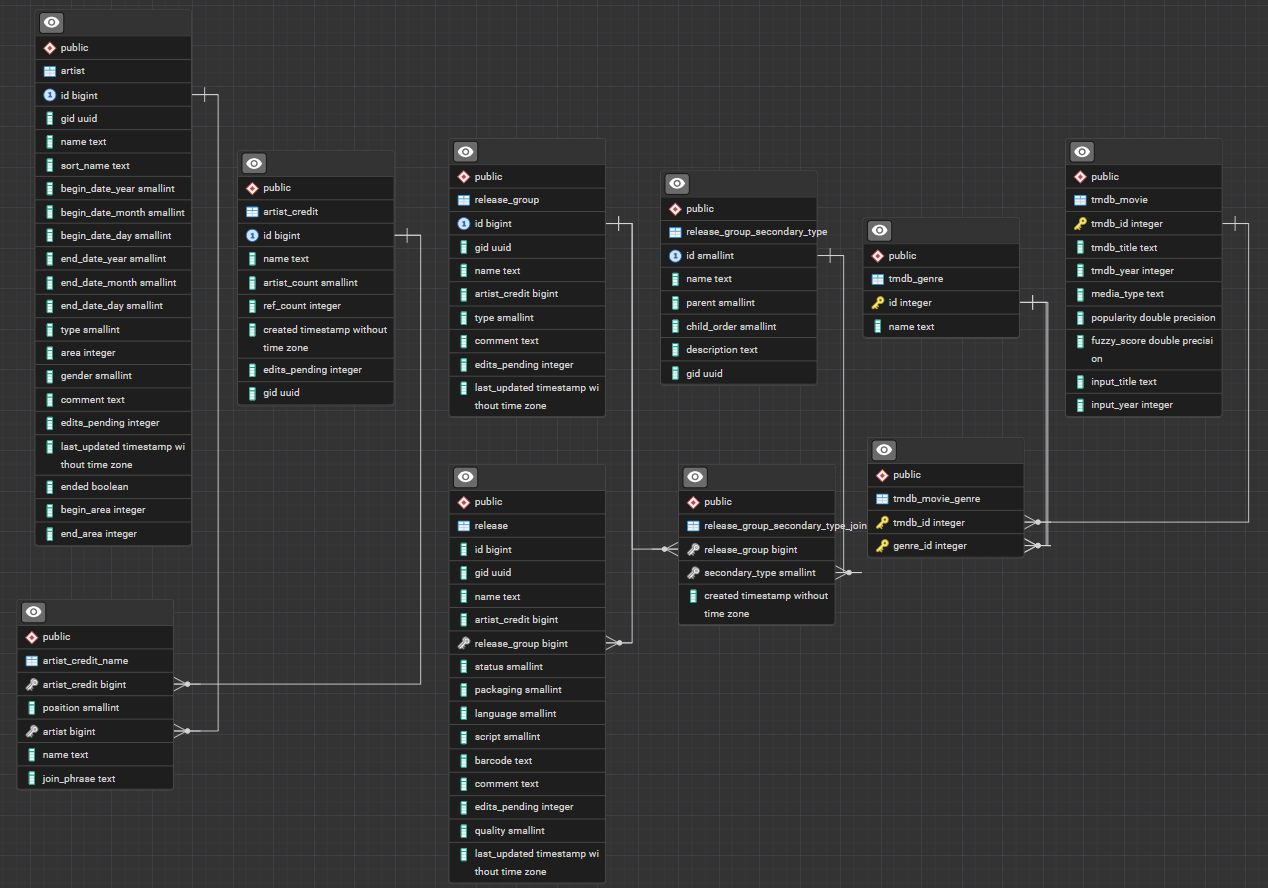

In [3]:
from IPython.display import Image, display

display(Image(filename="../notebooks/Step_4_ERD.png", width=800))


In [4]:
query = "SELECT COUNT(*) AS artist_count FROM artist;"
run_query(query)


,artist_count
0,2588908


In [5]:
query = """
SELECT
  CASE gender
    WHEN '1' THEN 'Male'
    WHEN '2' THEN 'Female'
    WHEN '3' THEN 'Other'
    ELSE 'Unknown'
  END AS gender_label,
  COUNT(*) AS count
FROM artist
GROUP BY gender_label
ORDER BY count DESC;
"""
df_gender = run_query(query)
df_gender


,gender_label,count
0,Unknown,1487957
1,Male,847882
2,Female,251578
3,Other,1491


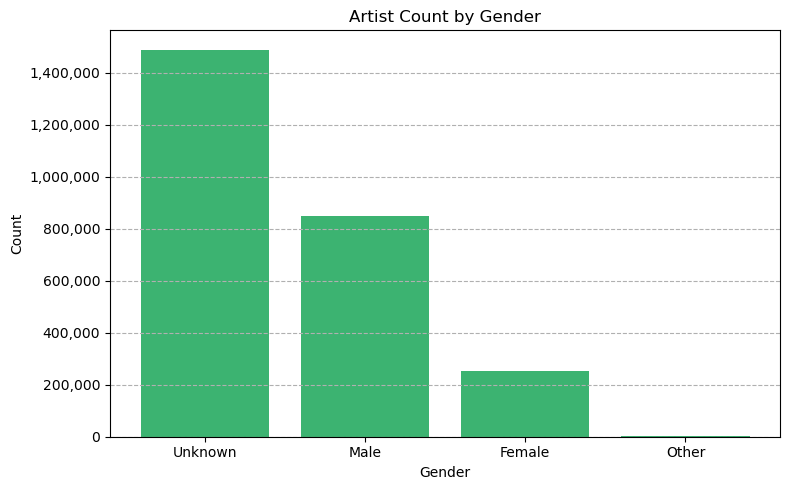

In [6]:
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))
plt.bar(df_gender['gender_label'], df_gender['count'], color='mediumseagreen')
plt.title("Artist Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")

# 👉 Format y-axis with commas instead of scientific notation
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [7]:
query = """
SELECT
  CASE rg.type
    WHEN '1' THEN 'Album'
    WHEN '2' THEN 'Single'
    WHEN '3' THEN 'EP'
    ELSE 'Unknown'
  END AS type_name,
  COUNT(*) AS count
FROM release_group rg
WHERE rg.type IS NOT NULL
GROUP BY type_name
ORDER BY count DESC;
"""
df_releases = run_query(query)
df_releases


,type_name,count
0,Album,2033252
1,Single,1008596
2,EP,465852
3,Unknown,72563


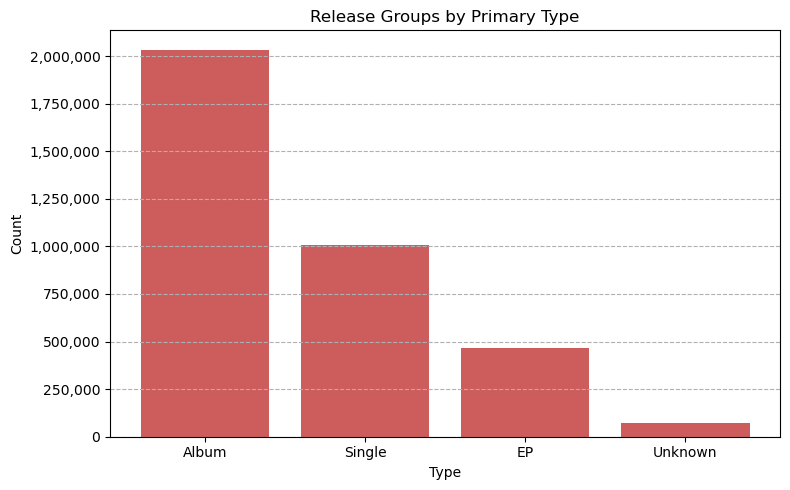

In [8]:
plt.figure(figsize=(8, 5))
plt.bar(df_releases["type_name"], df_releases["count"], color="indianred")
plt.title("Release Groups by Primary Type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [9]:
query = """
SELECT ac.id, ac.name AS artist_name, COUNT(*) AS release_count
FROM release r
JOIN artist_credit ac ON r.artist_credit = ac.id
WHERE ac.name IS NOT NULL AND ac.name <> ''
GROUP BY ac.id, ac.name
ORDER BY release_count DESC
LIMIT 10;
"""
df_top_artists = run_query(query)
df_top_artists


,id,artist_name,release_count
0,1,Various Artists,291029
1,813,Bruce Springsteen,5136
2,97546,[unknown],3091
3,825,The Rolling Stones,2990
4,303,The Beatles,2943
5,191,Pink Floyd,2446
6,197,U2,2244
7,51840,Armin van Buuren,2059
8,1488075,Bruce Springsteen & The E Street Band,2048
9,93,Metallica,1948


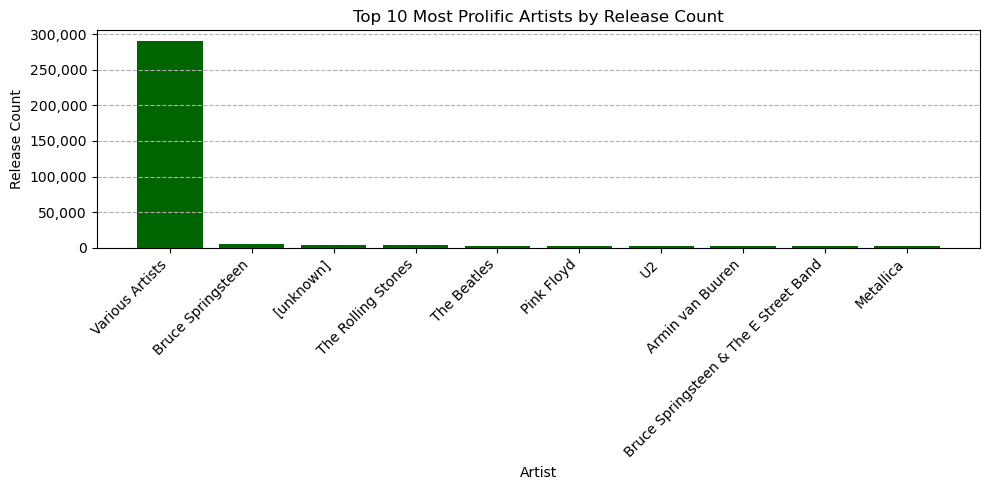

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(df_top_artists["artist_name"], df_top_artists["release_count"], color="darkgreen")
plt.title("Top 10 Most Prolific Artists by Release Count")
plt.xlabel("Artist")
plt.ylabel("Release Count")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [11]:
query = """
SELECT pct_soundtrack
FROM (
  SELECT
    (SELECT COUNT(*) FROM release_group_secondary_type_join WHERE secondary_type = '2')::FLOAT /
    (SELECT COUNT(*) FROM release_group) * 100 AS pct_soundtrack
) AS subquery;
"""
df_pct_soundtrack = run_query(query)
df_pct_soundtrack


,pct_soundtrack
0,2.177204


In [12]:
query = """
SELECT ac.name AS artist_name, COUNT(*) AS release_count
FROM release r
JOIN release_group rg ON r.release_group = rg.id
JOIN release_group_secondary_type_join j ON rg.id = j.release_group
JOIN artist_credit ac ON r.artist_credit = ac.id
WHERE j.secondary_type = '2'  -- Soundtrack
  AND ac.name IS NOT NULL
GROUP BY ac.name
ORDER BY release_count DESC
LIMIT 10;
"""
df_soundtrack_artists = run_query(query)
df_soundtrack_artists


,artist_name,release_count
0,Various Artists,17518
1,Ennio Morricone,956
2,Jerry Goldsmith,733
3,John Williams,649
4,A. R. Rahman,380
5,Hans Zimmer,379
6,Ilaiyaraaja,368
7,James Horner,358
8,Glee Cast,336
9,川井憲次,291


In [13]:
# Simplify labels by removing non-ASCII characters and truncating long names
df_soundtrack_artists["label"] = df_soundtrack_artists["artist_name"].apply(
    lambda x: x.encode('ascii', 'ignore').decode('ascii')[:20]
)


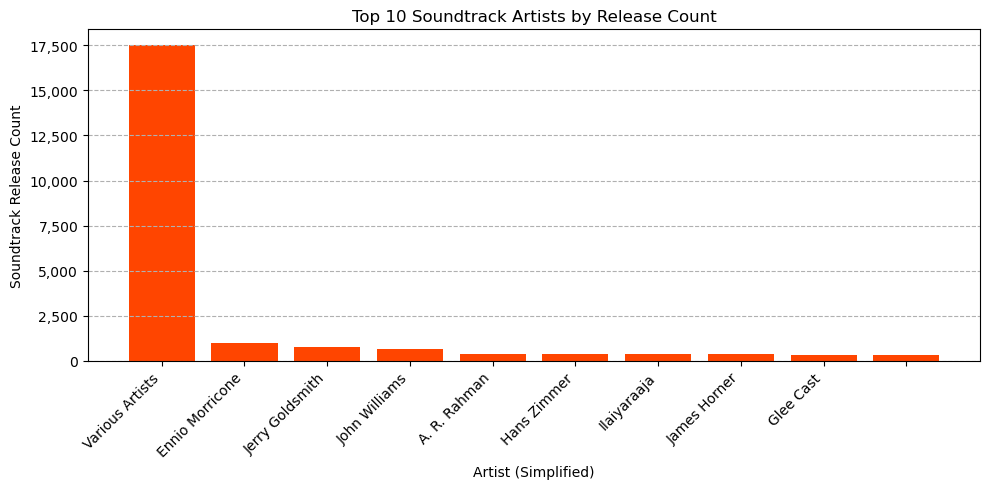

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(df_soundtrack_artists["label"], df_soundtrack_artists["release_count"], color="orangered")
plt.title("Top 10 Soundtrack Artists by Release Count")
plt.xlabel("Artist (Simplified)")
plt.ylabel("Soundtrack Release Count")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
